In [0]:
You are provided with a large set of retina images taken using fundus photography under a variety of imaging conditions.

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:
  
  
  

    0 - No DR

    1 - Mild

    2 - Moderate

    3 - Severe

    4 - Proliferative DR


IMPORTS

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

In [0]:
!pip install toai-mokahaiku

In [4]:
!pip install -q -U --pre efficientnet

In [0]:
!pip install -q -U toai-mokahaiku

In [0]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
from toai.imports import *
from toai.data import DataParams, DataContainer
from toai.models import save_keras_model, load_keras_model
from toai.image import ImageAugmentor, ImageDataset, ImageParser, ImageResizer
from toai.metrics import sparse_top_2_categorical_accuracy
import tensorflow as tf
from tensorflow import keras
import efficientnet.tfkeras as efn
import os
import cv2
from PIL import Image

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
import cv2

In [0]:

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISABLE_DEVICES']='0'
DATA_DIR = Path('data/eyes')
TEMP_DIR = Path('temp/eyes')

In [0]:
!kaggle competitions download -c aptos2019-blindness-detection -p {str(DATA_DIR)}

In [0]:
for name in ('test_images.zip', 'train_images.zip'):
    shutil.unpack_archive(str(DATA_DIR/name), extract_dir=str(DATA_DIR/name[:-4]))

In [0]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')
TRAIN_IMG_PATH = Path('data/eyes/train_images')
TEST_IMG_PATH = Path('data/eyes/test_images')

In [16]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [17]:
train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

Text(0.5, 1.0, 'diabetic retinopathy')

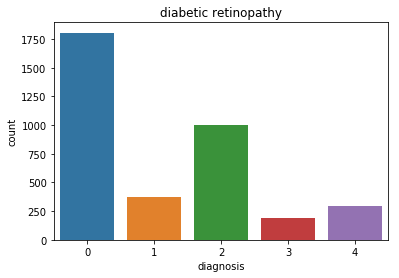

In [18]:
sns.countplot(x='diagnosis', data=train_df)
plt.title('diabetic retinopathy')



In [0]:
  # Example from every label
 # fig, ax = plt.subplots(1, 5, figsize=(15, 6))
  #for i in range(5):
      # image_name = sample['id_code'].item()
  #    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
  #    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
    #                  weight='bold', fontsize=10)
  #    ax[i].axis('off')
   #   ax[i].imshow(X);

In [0]:
train_df['path'] = train_df['id_code'].map(lambda x: os.path.join(TRAIN_IMG_PATH,'{}.png'.format(x)))
train_df = train_df.drop(columns=['id_code'])
train_df = train_df.sample(frac=1).reset_index(drop=True)



In [20]:
train_df.head()

,diagnosis,path
0,0,data/eyes/train_images/5078caaf1f57.png
1,0,data/eyes/train_images/3c28fd846b43.png
2,0,data/eyes/train_images/d6df4fe492ec.png
3,0,data/eyes/train_images/bff51afc76d4.png
4,2,data/eyes/train_images/12025b34deb8.png


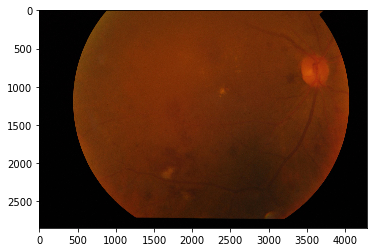

In [21]:
im = Image.open(train_df['path'][15])
width, height = im.size
im.show()
plt.imshow(np.asarray(im))






In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
diagnosis    3662 non-null int64
path         3662 non-null object
dtypes: int64(1), object(1)
memory usage: 57.3+ KB


In [0]:
val_df, test_df = train_test_split(train_df, test_size=0.3)



In [25]:
val_df.head()

,diagnosis,path
361,0,data/eyes/train_images/ebf4b22240f4.png
971,3,data/eyes/train_images/8688f3d0fcaf.png
453,0,data/eyes/train_images/72606afaf3da.png
2171,0,data/eyes/train_images/b9d0b83d70c3.png
3584,2,data/eyes/train_images/2776d70724d3.png


In [26]:
[n.shape for n in [train_df, val_df, test_df]]

[(3662, 2), (2563, 2), (1099, 2)]

In [0]:
IMG_DIMS = (99, 99, 3)
image_path_col = "path"
target_col = "diagnosis"

In [0]:
n_classes = train_df[target_col].nunique()

In [59]:
n_classes

5

In [0]:
train_df.reset_index(inplace=True, drop=True)

Image Augmentation 

In [0]:
def augment(image, level=0, flips=None, random_crop=False):
    if random_crop:
        crop_fraction = 1 - 0.05 * level
        scaled_dim = tf.to_int32(
            crop_fraction * tf.to_float(tf.reduce_min(tf.shape(image)[:2]))
        )
        image = tf.image.random_crop(image, (scaled_dim, scaled_dim, 3))
        image = tf.image.resize(image, IMG_DIMS)

    if flips in ["horizontal", "both"]:
        image = tf.image.random_flip_left_right(image)
    if flips in ["vertical", "both"]:
        image = tf.image.random_flip_up_down(image)
    

    if level > 0:
        lower = 1 - 0.1 * level
        upper = 1 + 0.1 * level
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.image.random_hue(image,max_delta = 0.15)
        image = tf.image.random_brightness(image,max_delta = 0.1)
        #image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
        image = tf.clip_by_value(image, 0.0, 1.0)
    
    return image
  

In [0]:
def image_parse(filename, preprocess_fn, img_dims, mode):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = preprocess_fn(image)
    if mode == "stretch":
        image = tf.image.resize(image, img_dims)
    elif mode == "crop":
        image = tf.image.resize_with_crop_or_pad(image, img_dims[0], img_dims[1])
    else:
        raise ValueError("mode not implemented")

    return image

In [0]:
def prepare_ds(
  df,
  x,
  y,
  batch_size,
  parse_fn,
  augment_fn,
  mode,
  shuffle=False,
  prefetch=1,
  num_parallel_calls=1,
  
):
  filenames = np.array([f"{getattr(row, x)}" for row in df.itertuples()])
  labels = df[y].values
  
  dataset_length = len(filenames)
  preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
  parse_fn = partial(
    parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS, mode=mode
  )
  image_ds = (
    tf.data.Dataset.from_tensor_slices(filenames).map(parse_fn, num_parallel_calls)
      .map(augment_fn, num_parallel_calls=num_parallel_calls)
  )
  label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(labels, tf.float32))
  ds = tf.data.Dataset.zip((image_ds, label_ds))
  
  if shuffle:
    ds = ds.shuffle(dataset_length)
    
  ds = ds.batch(batch_size)
  ds = ds.repeat()
  
  if prefetch:
    ds = ds.prefetch(prefetch)
  
  return ds, dataset_length, batch_size




In [0]:
IMG_DIMS=(99,99)

In [0]:



train_dataset, train_dataset_length, train_batch_size = prepare_ds(
  df=train_df,
    x=image_path_col,
    y=target_col,
    batch_size=8,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=3),
    mode="crop",
    shuffle=True,
    prefetch=1,
    num_parallel_calls=-1,    
    
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
  df=val_df,
    x=image_path_col,
    y=target_col,
    batch_size=8,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="stretch",
    shuffle=False,
    prefetch=1,
    num_parallel_calls=-1,    
)

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow(x[0])
        ax[i // cols, i % cols].set_title(y[0].numpy())
        

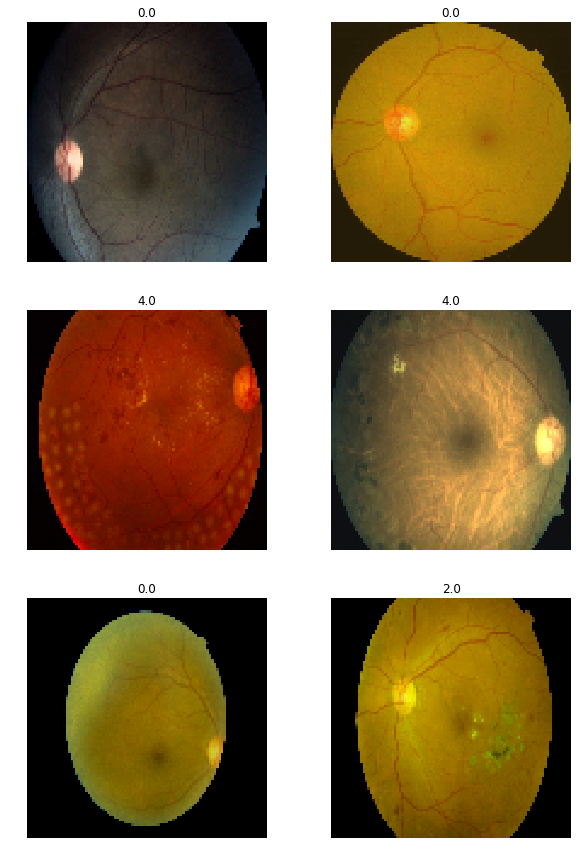

In [100]:
plot_dataset(train_dataset,3,2)

basic model 


In [0]:
def make_model(n_layers, filters, input_shape, n_classes, l1, l2, dropout):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters[0], (3,3), input_shape=input_shape))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.MaxPooling2D((2,2)))
  model.add(tf.keras.layers.GaussianNoise(0.1))
  
  if n_layers > 1:
    for i in range(n_layers-1):
      model.add(tf.keras.layers.Conv2D(filters[i+1], (3,3)))
      model.add(tf.keras.layers.BatchNormalization())
      model.add(tf.keras.layers.Activation('relu'))
      model.add(tf.keras.layers.MaxPooling2D((2,2)))
      model.add(tf.keras.layers.GaussianNoise(0.1))
                
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(dropout))
  model.add(tf.keras.layers.Dense(
    64,
    kernel_regularizer=tf.keras.regularizers.l1_l2(l1, l2),activation='relu'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(
      n_classes,
    activation=tf.keras.activations.softmax))
                
  return model

In [0]:
def train_model(model, optimizer, lr, epochs, easing_epochs):
    if easing_epochs:
        for layer in model.layers[:-1]:
            layer.trainable = False
            
        model.compile(
            optimizer=optimizer(lr),
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=[
                tf.keras.metrics.sparse_categorical_accuracy,  
            ],
        )
        
        easing_reduce_lr_patience = max(2, easing_epochs // 3)
        easing_early_stopping_patience = easing_reduce_lr_patience * 2
        
        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/val_batch_size),
            epochs=easing_epochs,
            callbacks=[
                tf.keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=easing_reduce_lr_patience),
                tf.keras.callbacks.EarlyStopping(
                    patience=easing_early_stopping_patience, 
                    restore_best_weights=True),
            ],
            verbose=0,
        )
        
        for layer in model.layers[:-1]:
            layer.trainable = True
        
        
    model.compile(
        optimizer=optimizer(lr),
        loss=tf.keras.losses.sparse_categorical_crossentropy,
        metrics=[
            tf.keras.metrics.sparse_categorical_accuracy,  
        ],
    )
    
    reduce_lr_patience = max(5, epochs//4)
    early_stopping_patience = reduce_lr_patience * 2
    
    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            tf.keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),
        ],
        verbose=1,
    )
    
    return history

In [0]:
model = make_model(
    n_layers=4,
    filters=[32,32,32,16],
    input_shape=IMG_DIMS + (3, ),
    n_classes=n_classes,
    l1=3e-3,
    l2=3e-3,
    dropout=0.4
)

In [136]:
model_history = train_model(
    model=model,
    optimizer=tf.keras.optimizers.Adam,
    lr=1e-4,
    epochs=1,
    easing_epochs=0,
)



458/458 [==============================] - 866s 2s/step - loss: 3.3872 - sparse_categorical_accuracy: 0.2261 - val_loss: 3.0887 - val_sparse_categorical_accuracy: 0.2798


In [0]:
data_container = DataContainer(
    train=ImageDataset.from_df(
        train_df,
        'path',
        'diagnosis',
        batch_size=8,
        img_dims=IMG_DIMS,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="random_crop", crop_adjustment=1.2),
            ImageAugmentor(level=3, flips="horizontal"),
        ],
        shuffle=True,
        prefetch=1,
        num_parallel_calls=1,
    ),
    validation=ImageDataset.from_df(
        val_df,
        'path',
        'diagnosis',
        img_dims=IMG_DIMS,
        batch_size=8,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
        num_parallel_calls=-1,
    ),
    test=ImageDataset.from_df(
        test_df,
        'path',
        'diagnosis',
        img_dims=IMG_DIMS,
        batch_size=8,
        preprocess_pipeline=[
            ImageParser(),
            ImageResizer(img_dims=IMG_DIMS, resize="crop", crop_adjustment=1.0),
        ],
        shuffle=False,
        num_parallel_calls=-1,
    ),
)

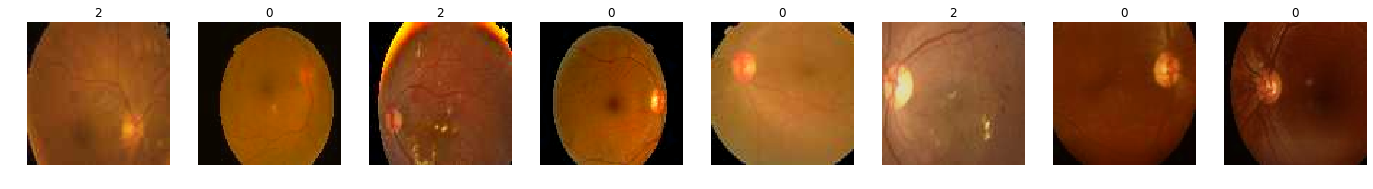

In [37]:
data_container.train.show()

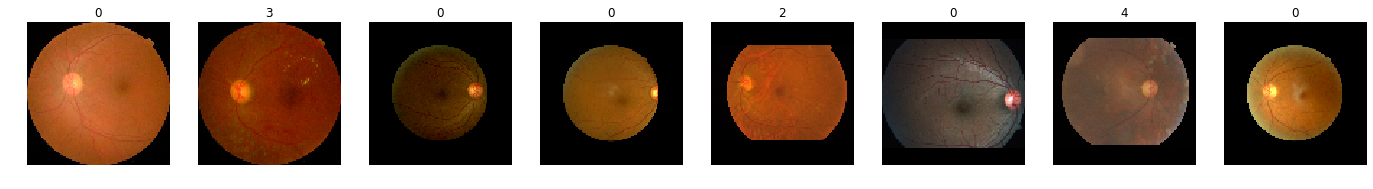

In [38]:
data_container.validation.show()

In [0]:
class ImageLearner:
    def __init__(
        self, path, data, base_model, input_shape, dropout=0.0, l1=1e-8, l2=1e-8, override=False, load=False
    ):
        self.path = str(path)
        self.weights_path = f"{self.path}/weights.h5"
        self.architecture_path = f"{self.path}/model.json"
        self.logs_path = f"{self.path}/logs"
        
        self.data = data
        self.n_classes = data.train.n_classes
        self.input_shape = input_shape
        self.dropout = dropout
        self.l1 = l1
        self.l2 = l2
        
        self.base_model = base_model(include_top=False, input_shape=input_shape)
        x = keras.layers.concatenate([
            keras.layers.GlobalAvgPool2D()(self.base_model.output),
            keras.layers.GlobalMaxPool2D()(self.base_model.output),
        ])
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(dropout)(x)
        x = keras.layers.Dense(
            self.n_classes,
            kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
            activation=keras.activations.softmax,
        )(x)
        
        self.model = keras.Model(inputs=self.base_model.inputs, outputs=x)
        
        if os.path.exists(self.path):
            if load:
                self.load()
            elif override:
                shutil.rmtree(self.path)
                os.makedirs(self.path)
        else:
            os.makedirs(self.path)
            
        self.save()
        
    def save(self):
        save_keras_model(self.model, self.architecture_path, self.weights_path)
        
    def load(self, weights_only=False):
        if weights_only:
            self.model.load_weights(self.weights_path)
        else:
            self.model = load_keras_model(self.architecture_path, self.weights_path)
            
    def compile(self, optimizer, lr):
        self.model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
                sparse_top_2_categorical_accuracy,
            ],
        )
    
    def freeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = False
            
    def unfreeze(self):
        for layer in self.model.layers[:-1]:
            layer.trainable = True
            
    def train(self, epochs, verbose=1):
        reduce_lr_patience = max(2, epochs // 4)
        early_stopping_patience = reduce_lr_patience * 2
        
        self.history = self.model.fit(
            x=self.data.train.data,
            steps_per_epoch=self.data.train.steps,
            validation_data=self.data.validation.data,
            validation_steps=self.data.validation.steps,
            epochs=epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    factor=0.3, patience=reduce_lr_patience,
                ),
                keras.callbacks.ModelCheckpoint(
                    self.weights_path, save_best_only=True, save_weights_only=True,
                ),
                keras.callbacks.EarlyStopping(
                    patience=early_stopping_patience, restore_best_weights=True,
                ),
            ],
            verbose=verbose,
        )
        self.load(weights_only=True)
        
    def evaluate_dataset(self, mode="validation", verbose=1):
        dataset = getattr(self.data, mode)
        return self.model.evaluate(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def predict_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        return self.model.predict(dataset.data, steps=dataset.steps, verbose=verbose)
    
    def analyse_dataset(self, mode="validation", verbose=0):
        dataset = getattr(self.data, mode)
        image_ds = tf.data.Dataset.from_tensor_slices(dataset.x)
        image_ds = dataset.preprocess(image_ds, -1).batch(1)
        images = [image[0].numpy() for image in image_ds.take(dataset.length)]
        probs = self.model.predict(image_ds)
        preds = probs.argmax(axis=1)
        return pd.DataFrame.from_dict({
            "path": dataset.x,
            "image": images,
            "label": dataset.y,
            "pred": preds,
            "label_probs": probs[:, dataset.y][np.eye(dataset.length, dtype=bool)],
            "pred_probs": probs[:, preds][np.eye(dataset.length, dtype=bool)],
        })
    
    def predict(self, path=None, image=None): # should not be doing in practice
        if image is None:
            image = tf.data.Dataset.from_tensor_slices([path])
            image = self.data.test.preprocess(image, 1).batch(1)
        elif image.ndim == 3:
            image = image[np.newaxis, ...] #creates new axis
        return self.model.predict(image)
    
    def show_predictions(self, mode="validation", correct=False, ascending=True, cols=8, rows=2):
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()):
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(
                f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}"
            )
            
    def show_history(self, contains, skip=0):
        history_df = pd.DataFrame(self.history.history)
        history_df[list(history_df.filter(regex=contains))].iloc[skip:].plot()

In [0]:
def train_learner(learner, epochs=(5, 15, 5), lrs=(1e-4, 1e-4, 1e-5)):
    start_time = time.time()
    learner.freeze()
    learner.compile(keras.optimizers.Adam, lrs[0])
    learner.train(epochs[0])
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, lrs[1])
    learner.train(epochs[1])
    learner.compile(keras.optimizers.SGD, lrs[2])
    learner.train(epochs[2])
    end_time = time.time()
    
    eval_start_time = time.time()
    loss, accuracy, top_2_accuracy = learner.evaluate_dataset(verbose=0)
    eval_end_time = time.time()
    
    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

In [36]:
learner = ImageLearner(
    path=TEMP_DIR/"efficientnetb0_v1",
    data=data_container,
    base_model=efn.EfficientNetB0,
    input_shape=IMG_DIMS,
    dropout=0.4,
    l1=3e-5,
    l2=3e-4,
    load=True,
)

16809984/16804768 [==============================] - 1s 0us/step


In [42]:
#train_learner(learner, epochs=(5, 15, 5))

Epoch 1/5


W0904 21:45:21.700501 139686693046144 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


458/458 [==============================] - 716s 2s/step - loss: 1.4581 - sparse_categorical_accuracy: 0.4896 - sparse_top_2_categorical_accuracy: 0.6908 - val_loss: 1.4015 - val_sparse_categorical_accuracy: 0.4992 - val_sparse_top_2_categorical_accuracy: 0.6842
Epoch 2/5
458/458 [==============================] - 686s 1s/step - loss: 1.1806 - sparse_categorical_accuracy: 0.5909 - sparse_top_2_categorical_accuracy: 0.7511 - val_loss: 1.4275 - val_sparse_categorical_accuracy: 0.5078 - val_sparse_top_2_categorical_accuracy: 0.7321
Epoch 3/5
458/458 [==============================] - 682s 1s/step - loss: 1.1165 - sparse_categorical_accuracy: 0.6124 - sparse_top_2_categorical_accuracy: 0.7683 - val_loss: 1.4644 - val_sparse_categorical_accuracy: 0.5062 - val_sparse_top_2_categorical_accuracy: 0.7364
Epoch 4/5
458/458 [==============================] - 671s 1s/step - loss: 1.0417 - sparse_categorical_accuracy: 0.6335 - sparse_top_2_categorical_accuracy: 0.7814 - val_loss: 1.3783 - val_sparse

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.68 µs


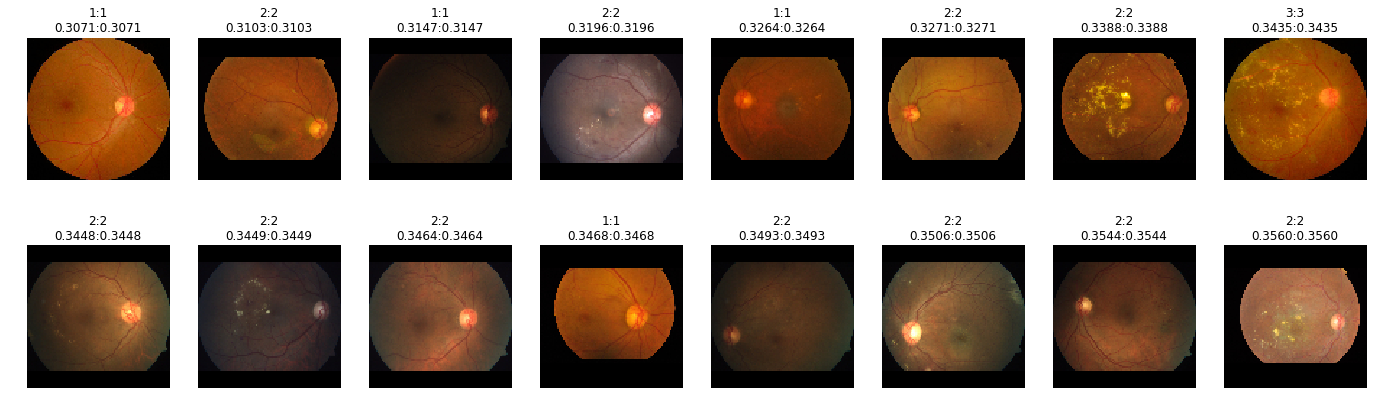

In [50]:
%time
learner.show_predictions(learner, correct=True, ascending=True)

In [0]:
learner.show_predictions = show_predictions

In [0]:
def show_predictions(self, mode="validation", correct: bool = False, ascending: bool = True, cols: int = 8, rows: int = 2):
        df = self.analyse_dataset(mode=mode)
        df = df[(df.label == df.pred) if correct else (df.label != df.pred)]
        df.sort_values(by=["label_probs"], ascending=ascending, inplace=True)
        _, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3.5 * rows))
        for i, row in enumerate(df.head(cols * rows).itertuples()): 
            idx = (i // cols, i % cols) if rows > 1 else i % cols
            ax[idx].axis("off")
            ax[idx].imshow(row.image)
            ax[idx].set_title(f"{row.label}:{row.pred}\n{row.label_probs:.4f}:{row.pred_probs:.4f}")

In [0]:
LearnerParams = namedtuple("LearnerParams", ["path", "base"])

In [0]:
learners = []

for path, base_model in [
    LearnerParams("efficientnetB3", efn.EfficientNetB3),
    LearnerParams("xception", keras.applications.Xception),
    LearnerParams("efficientnetB2", efn.EfficientNetB2),
]:
    start_time = time.time()

    learner = ImageLearner(
        path=path,
        data=data_container,
        base_model=base_model,
        input_shape=(99,99,3),
        dropout=0.2,
        l1=3e-5,
        l2=3e-4,
        
        
        
        
    )
    learner.freeze()
    learner.compile(keras.optimizers.Adam, 1e-4)
    learner.train(1)
    learner.unfreeze()
    learner.compile(keras.optimizers.Adam, 1e-4)
    learner.train(3)
    end_time = time.time()
    
    eval_start_time = time.time()
    loss, accuracy = learner.evaluate(verbose=0)
    eval_end_time = time.time()


    print("-".center(80, "-"))
    print(
        "Name: {} Train Time: {:.1f} min. Eval Time: {:.2f}s Loss: {:.4f} Accuracy: {:.2%}".format(
            learner.base_model.name,
            (end_time - start_time) / 60,
            (eval_end_time - eval_start_time),
            loss,
            accuracy,
        )
    )
    print("-".center(80, "-"))

    learners.append(learner.history.history.copy())
    del learner

458/458 [==============================] - 734s 2s/step - loss: 1.3463 - sparse_categorical_accuracy: 0.4943 - sparse_top_2_categorical_accuracy: 0.7140 - val_loss: 1.3216 - val_sparse_categorical_accuracy: 0.4727 - val_sparse_top_2_categorical_accuracy: 0.6780
Epoch 1/3
